# Experiments and investigation
Generally one can consider two settings that could be interesting to investigate:
- Decaying the impact of the teacher model with the epochs. As the student becomes better, the hints might become a restriction and the student might overfit to the teacher.
- Despite the teacher being better than the student, it still creates errors and adapting the tranferred knowledge to only include those samples that the teacher predicts correctly, might allow the student to more freely learn what the teacher can not. One could consider a focal loss kind of approach as an soft alternative.

In [1]:
import torch
import torch.nn as nn
from distillation.hintonDistiller import HintonDistiller
from distillation.utils import CNN, Accuracy
from torchvision import datasets, transforms
from trainer.baseTrainer import BaseTrainer

ModuleNotFoundError: No module named 'tensorboard'

In [5]:
# Initialize random models and distiller
imgSize = (1, 28, 28)
batchSize = 256

# Prepare data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/',
                   train=True,
                   download=True,
                   transform=transform
                  ),
    batch_size=batchSize)

validloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/',
                   train=False,
                   download=True,
                   transform=transform
                  ),
    batch_size=batchSize)

## Train teacher on MNIST

In [6]:
EPOCHS = 5

In [ ]:
teacher = CNN(imgSize, 10)

# Initialize objectives and optimizer
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher.parameters(), lr=1e-2)
metric = Accuracy(OH=False)

# Initialize trainer
trainer = BaseTrainer()

# Load state if checkpoint is provided otherwise .load_state merely returns 1 as startEpoch
checkpoint = None
startEpoch = trainer.load_state(checkpoint, teacher, optimizer)

# Construct checkpoint directory
trainer.save(0, teacher, optimizer, {}, subDirectory='train')
print('Saves checkpoint in {:s}'.format(trainer.checkpointDir))

print('\n========= Training =========')
for epoch in range(startEpoch, EPOCHS+1):
    # Training step for one full epoch
    trainMetrics = trainer.train_step(model=teacher,
                                      dataloader=trainloader,
                                      objective=objective,
                                      metric=metric,
                                      optimizer=optimizer)
        
    # Validation step for one full epoch
    validMetrics = trainer.validate(model=teacher,
                                    dataloader=validloader,
                                    objective=objective,
                                    metric=metric)

    metrics = {**trainMetrics, **validMetrics}

    # Save teacher
    trainer.save(epoch, teacher, optimizer, metrics, subDirectory='train')
        
    # Print epoch performance
    trainer.print_epoch(epoch, EPOCHS, metrics)

Saves checkpoint in checkpoint/train/20200909-155707

========= Training =========
Epoch:   1/5	 Train/Loss: 0.409	 Train/Metric: 0.889	 Valid/Loss: 0.208	 Valid/Metric: 0.939
Epoch:   2/5	 Train/Loss: 0.172	 Train/Metric: 0.952	 Valid/Loss: 0.156	 Valid/Metric: 0.955
Epoch:   3/5	 Train/Loss: 0.133	 Train/Metric: 0.964	 Valid/Loss: 0.128	 Valid/Metric: 0.964


## Distill with Hinton KD
You can consider the teacher as the student trained from scratch in this setting.

In [19]:
student = CNN(imgSize, 10)
distiller = HintonDistiller(alpha=0.1,
                            studentLayer=-1,
                            teacherLayer=-1)

# Initialize objectives and optimizer
objective = nn.CrossEntropyLoss()
distillObjective = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.SGD(student.parameters(), lr=1e-2)

# Load state if checkpoint is provided
checkpoint = None
startEpoch = distiller.load_state(checkpoint, student, teacher, optimizer)
epochs = 5

distiller.save(0, student, teacher, optimizer, 'distill')
print('Saves checkpoint in {:s}'.format(distiller.checkpointDir))

print('\n========= Distilling =========')
for epoch in range(startEpoch, epochs+1):
        # Training step for one full epoch
        trainMetrics = distiller.train_step(student=student,
                                            teacher=teacher,
                                            dataloader=trainloader,
                                            optimizer=optimizer,
                                            objective=objective,
                                            distillObjective=distillObjective)
        
        # Validation step for one full epoch
        validMetrics = distiller.validate(student=student,
                                          dataloader=validloader,
                                          objective=objective)
        metrics = {**trainMetrics, **validMetrics}

        # Save model
        distiller.save(epoch, student, teacher, optimizer, 'distill')
        
        # Print epoch performance
        distiller.print_epoch(epoch, epochs, metrics)

Saves checkpoint in checkpoint/distill/20200908-134220

========= Distilling =========
Epoch:   1/5	 Train/Loss: 0.328	 Train/Accuracy: 0.884	 Valid/Loss: 0.221	 Valid/Accuracy: 0.938
Epoch:   2/5	 Train/Loss: 0.069	 Train/Accuracy: 0.945	 Valid/Loss: 0.180	 Valid/Accuracy: 0.949
Epoch:   3/5	 Train/Loss: 0.045	 Train/Accuracy: 0.955	 Valid/Loss: 0.159	 Valid/Accuracy: 0.954
Epoch:   4/5	 Train/Loss: 0.033	 Train/Accuracy: 0.960	 Valid/Loss: 0.146	 Valid/Accuracy: 0.958
Epoch:   5/5	 Train/Loss: 0.026	 Train/Accuracy: 0.964	 Valid/Loss: 0.137	 Valid/Accuracy: 0.960


## Decaying teacher weight

$$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right)$$

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [103]:
class TeacherAnnealing(object):
    """
    Updates the (1-alpha)-weight for knowledge distillation according to CosineAnnealing
    \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} -
        \eta_{min})\left(1 + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right)
    """
    def __init__(self, distiller, endVal, epochs):
        """
        Args:
            distiller: distiller to update. Must have alpha attribute
            endVal: val to anneal to in èpochs` iterations
            epochs: amouint of iterations to reach `endVal`
        """
        self.distiller = distiller
        self.etaMax = self.distiller.alpha
        self.etaMin = endVal
        self.tMax = epochs
        self.tCur = 0
        
    def reset(self):
        self.tCur = 0
        self.distiller.alpha = self.etaMax
    
    def step(self):
        self.tCur += 1
        self.distiller.alpha = 1-(self.etaMin + 0.5*(self.etaMax - self.etaMin)*(1 + torch.cos(self.tCur/self.tMax * torch.tensor(np.pi))))
        
    def get_val(self):
        return self.distiller.alpha

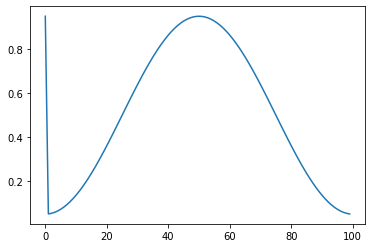

In [110]:
teacherSchedule = TeacherAnnealing(distiller, 0.05, 50)

vals = []
for i in range(100):
    vals.append(teacherSchedule.get_val())
    teacherSchedule.step()
    #if i % 50 == 0:
    #    teacherSchedule.reset()

plt.plot(vals);

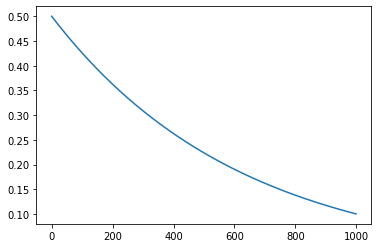

In [126]:
alpha = 0.5
def EDA(alpha, n, lambd=2):
    epochs = np.arange(n)
    return alpha*lambd**(epochs/n)

plt.plot(EDA(alpha, 1000, 0.2));

In [113]:
epochs = 5
student = CNN(imgSize, 10)
distiller = HintonDistiller(alpha=0.5,
                            studentLayer=-1,
                            teacherLayer=-1)

# Initialize objectives and optimizer
objective = nn.CrossEntropyLoss()
distillObjective = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.SGD(student.parameters(), lr=1e-2)
teacherSchedule = TeacherAnnealing(distiller, 0.05, epochs)

# Load state if checkpoint is provided
checkpoint = None
startEpoch = distiller.load_state(checkpoint, student, teacher, optimizer)

distiller.save(0, student, teacher, optimizer, 'distill')
print('Saves checkpoint in {:s}'.format(distiller.checkpointDir))

print('\n========= Distilling =========')
for epoch in range(startEpoch, epochs+1):
        # Training step for one full epoch
        trainMetrics = distiller.train_step(student=student,
                                            teacher=teacher,
                                            dataloader=trainloader,
                                            optimizer=optimizer,
                                            objective=objective,
                                            distillObjective=distillObjective)
        
        # Validation step for one full epoch
        validMetrics = distiller.validate(student=student,
                                          dataloader=validloader,
                                          objective=objective)
        metrics = {**trainMetrics, **{'alpha': distiller.alpha}, **validMetrics}

        # Save model
        distiller.save(epoch, student, teacher, optimizer, 'distill')
        
        # Print epoch performance
        distiller.print_epoch(epoch, epochs, metrics)
        
        # Schedule step
        teacherSchedule.step()

Saves checkpoint in checkpoint/distill/20200908-145121

========= Distilling =========
Epoch:   1/5	 Train/Loss: 0.328	 Train/Accuracy: 0.891	 alpha: 0.500	 Valid/Loss: 0.212	 Valid/Accuracy: 0.939
Epoch:   2/5	 Train/Loss: 0.119	 Train/Accuracy: 0.951	 alpha: 0.543	 Valid/Loss: 0.163	 Valid/Accuracy: 0.954
Epoch:   3/5	 Train/Loss: 0.101	 Train/Accuracy: 0.963	 alpha: 0.655	 Valid/Loss: 0.137	 Valid/Accuracy: 0.962
Epoch:   4/5	 Train/Loss: 0.098	 Train/Accuracy: 0.969	 alpha: 0.795	 Valid/Loss: 0.118	 Valid/Accuracy: 0.967
Epoch:   5/5	 Train/Loss: 0.095	 Train/Accuracy: 0.973	 alpha: 0.907	 Valid/Loss: 0.105	 Valid/Accuracy: 0.970


# Adaptive distillation weighting
## Focal KLD
Consider the binary focal loss $$FL(p_t) = -(1-p_t)^\gamma \log(p_t),$$
where $\gamma > 1$ punish less when the prediction is correct, but not confident, than when it is faulty. I.e. when $p_{t} \approx 0$, the loss is much larger, but if $pt_ \approx 1$, the loss is much smaller.
Now consider a similar setting for the KL Divergence of two distributions $p_t$, and $p_s$:
$$FKLD(p_t, p_s) = -{p^i_t}^\gamma KLD(p_t, p_s)$$
where $p^i_t$ is the probability of the true class, and thus the KLD is reduced much when the teacher is wrong and little when the teacher is correct.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

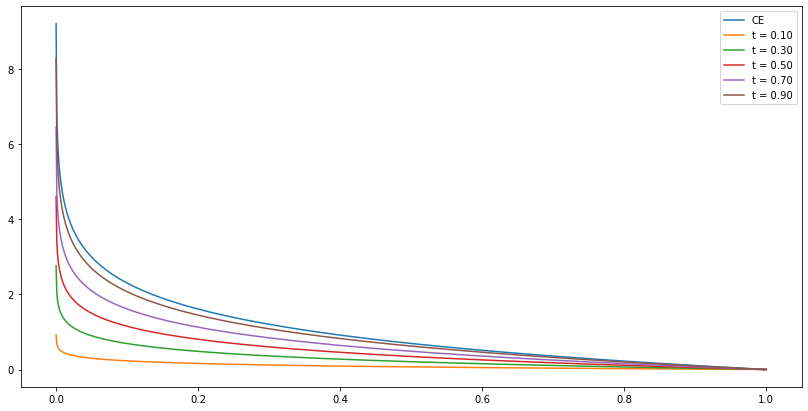

In [90]:
p = np.linspace(0.0001,1,1000)
ce = -np.log(p)

plt.figure(figsize=(14,7))
plt.plot(p, ce, label='CE')
#plt.ylim(0,6)

for t in np.linspace(0.1,0.9,5):
    plt.plot(p, -t*np.log(p), label=f't = {t:1.2f}')
plt.legend();

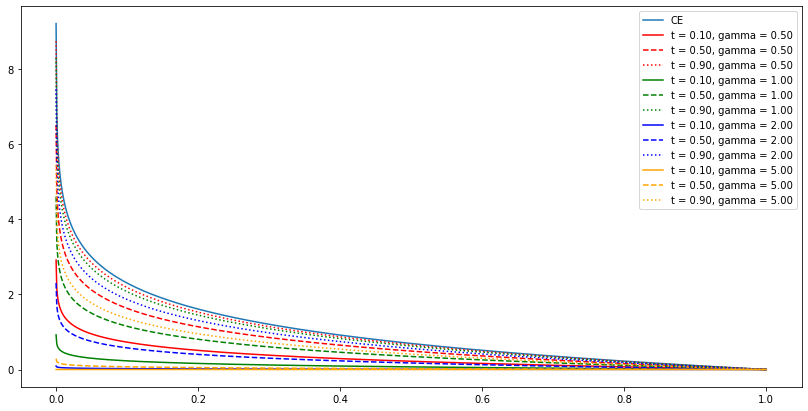

In [93]:
p = np.linspace(0.0001,1,1000)
ce = -np.log(p)

plt.figure(figsize=(14,7))
plt.plot(p, ce, label='CE')
#plt.ylim(0,6)

lstyle = ['-', '--', ':']
lcolor = ['red', 'green', 'blue', 'orange', 'purple']
i = -1
for gamma in (0.5, 1, 2, 5):
    i += 1
    j =-1
    for t in np.linspace(0.1,0.9,3):
        j += 1
        plt.plot(p, -t**gamma*np.log(p), linestyle=lstyle[j], color=lcolor[i], label=f't = {t:1.2f}, gamma = {gamma:1.2f}')
plt.legend();

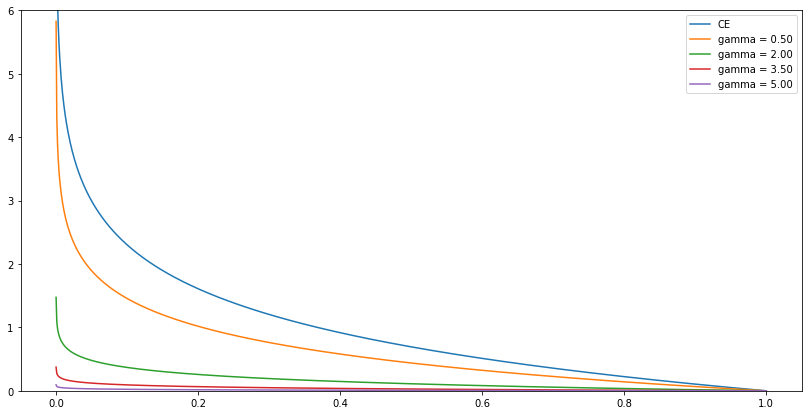

In [106]:
p = np.linspace(0.0001,1,1000)
ce = -np.log(p)

plt.figure(figsize=(14,7))
plt.ylim(0,6)
plt.plot(p, -np.log(p), label='CE')

for gamma in np.linspace(0.5,5,4):
    t = 0.4
    plt.plot(p, -t**gamma*np.log(p), label=f'gamma = {gamma:1.2f}')
plt.legend();

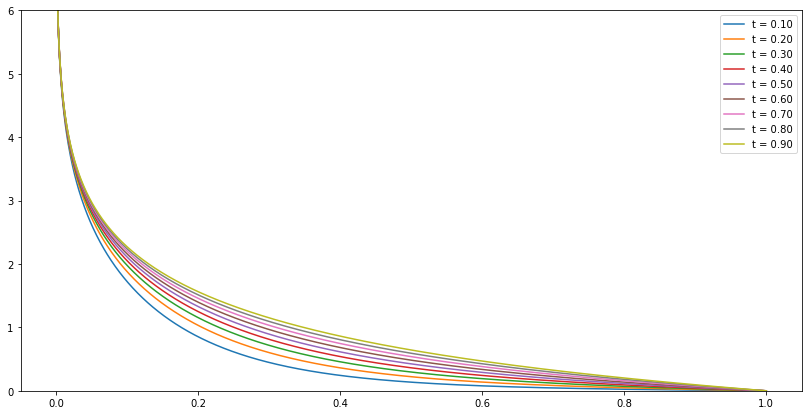

In [110]:
p = np.linspace(0.0001,1,1000)
ce = -np.log(p)

plt.figure(figsize=(14,7))
plt.ylim(0,6)

for t in np.linspace(0.1,0.9, 9):
    plt.plot(p, -(t**(p**(1-p)))*np.log(p), label=f't = {t:1.2f}')
plt.legend();

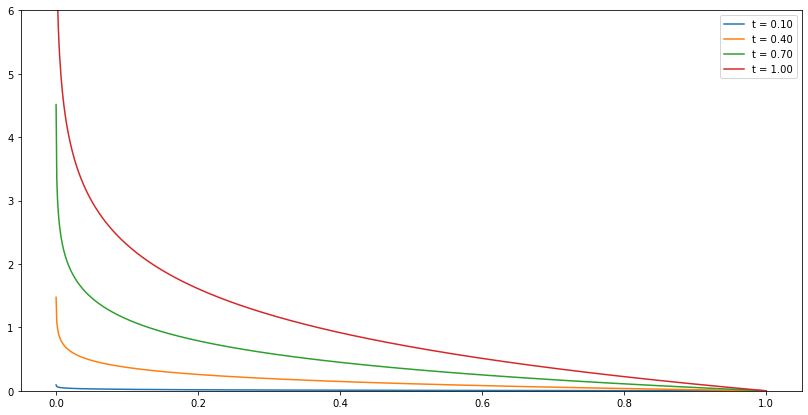

In [74]:
p = np.linspace(0.0001,1,1000)
ce = -np.log(p)

plt.figure(figsize=(14,7))
plt.ylim(0,6)
gamma = 2
for t in np.linspace(0.1, 1, 4):
    plt.plot(p, -t**gamma*np.log(p), label=f't = {t:1.2f}')
plt.legend();

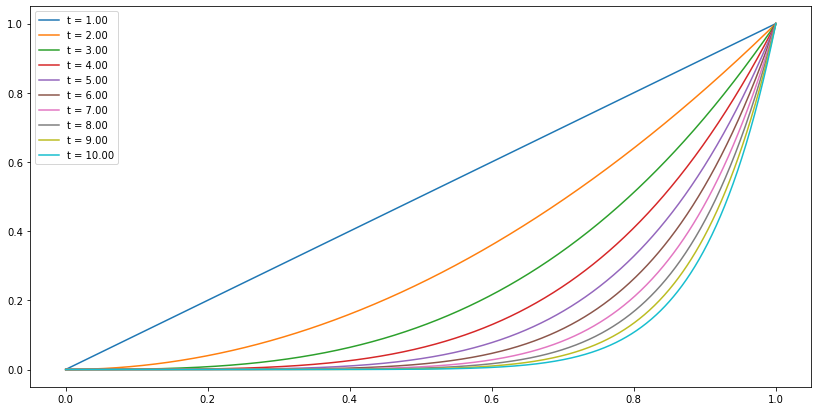

In [120]:
t = np.linspace(0.0001,1,1000)

plt.figure(figsize=(14,7))
for gamma in np.linspace(1, 10, 10):
    plt.plot(t, t**gamma, label=f't = {gamma:1.2f}')
plt.legend();

## PyTorch implementation

In [ ]:
class FocalKLD(object):
    """Focal-like weighting of KLD"""
    def __call__(self, yTrue, yStudent, yTeacher):
        weights = yTeacher[torch.arange(yTeacher.size(0)), yTrue]
        kld = torch.nn.functional.kl_div(yTeacher, yStudent, reduction='none')
        return torch.sum(weights.unsqueeze(1)*kld, axis=1).mean()

In [ ]:
y_true = torch.tensor([2,3,4])
y_student = torch.softmax(torch.rand((3,8)), 1)
y_teacher = torch.softmax(torch.rand((3,8)), 1)
print(y_true)
print(y_student)
print(y_teacher)

focalkld = FocalKLD()
print(focalkld(y_true, y_student, y_teacher))
torch.nn.functional.kl_div(y_teacher, y_student, reduction='batchmean')

In [ ]:
import torch
import torch.nn as nn
from distillation.utils import Accuracy, AverageMeter, Hook
from distillation.baseDistiller import BaseDistiller

class HintonDistiller(BaseDistiller):
    def __init__(self, alpha, studentLayer=-2, teacherLayer=-2):
        super(HintonDistiller, self).__init__()
        
        self.alpha = alpha
        self.studentLayer = studentLayer
        self.teacherLayer = teacherLayer
        
        # Register hooks
        self.studentHook = Hook()
        self.teacherHook = Hook()

    def train_step(self, student, teacher, dataloader, optimizer, objective, distillObjective, OneHot=False):
        """
        Train student model to the teacher model for one epoch with Hinton KD.
        
        :return: dict, named metrics for logging.
        """
        student.train()
        teacher.eval()
        
        # Attach
        if not self.studentHook.hooked():
            self._setHook(self.studentHook, student, self.studentLayer)
        if not self.teacherHook.hooked():
            self._setHook(self.teacherHook, teacher, self.teacherLayer)

        device = next(student.parameters()).device
        accuracy = Accuracy(OH=OneHot)
        lossMeter = AverageMeter()
        accMeter = AverageMeter()
        
        for _, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)

            # Calculate logits
            sLogits = student(data)
            tLogits = teacher(data)
            
            # Retrieve activations from distillation layer of both models
            sAct = self.studentHook.val()
            tAct = self.teacherHook.val()
            
            # Calculate loss
            optimizer.zero_grad()
            batchLoss = (1-self.alpha)*distillObjective(target, nn.functional.log_softmax(sAct, dim=1), nn.functional.softmax(tAct, dim=1))
            batchLoss += self.alpha*objective(nn.functional.log_softmax(sLogits, dim=1), target)

            # Update student weights
            batchLoss.backward()
            optimizer.step()
            
            # Save metrics
            lossMeter.update(batchLoss.item(), n=len(data))
            accMeter.update(accuracy(nn.functional.softmax(sLogits, dim=1), target), n=len(data))
        
        return {'Train/Loss': lossMeter.avg,
                'Train/Accuracy': accMeter.avg}


In [3]:
epochs = 5
student = CNN(imgSize, 10)
distiller = HintonDistiller(alpha=0.5,
                            studentLayer=-1,
                            teacherLayer=-1)

# Initialize objectives and optimizer
objective = nn.CrossEntropyLoss()
distillObjective = FocalKLD()
optimizer = torch.optim.SGD(student.parameters(), lr=1e-2)

# Load state if checkpoint is provided
checkpoint = None
startEpoch = distiller.load_state(checkpoint, student, teacher, optimizer)

distiller.save(0, student, teacher, optimizer, 'distill')
print('Saves checkpoint in {:s}'.format(distiller.checkpointDir))

print('\n========= Distilling =========')
for epoch in range(startEpoch, epochs+1):
        # Training step for one full epoch
        trainMetrics = distiller.train_step(student=student,
                                            teacher=teacher,
                                            dataloader=trainloader,
                                            optimizer=optimizer,
                                            objective=objective,
                                            distillObjective=distillObjective)
        
        # Validation step for one full epoch
        validMetrics = distiller.validate(student=student,
                                          dataloader=validloader,
                                          objective=objective)
        metrics = {**trainMetrics, **{'alpha': distiller.alpha}, **validMetrics}

        # Save model
        distiller.save(epoch, student, teacher, optimizer, 'distill')
        
        # Print epoch performance
        distiller.print_epoch(epoch, epochs, metrics)
        
        # Schedule step
        teacherSchedule.step()

NameError: name 'CNN' is not defined